In [1]:
import networkx as nx
import numpy as np
import functools
import random


In [2]:
from optiLib.problem import NetGraph
from optiLib.problem import TaskGraph

def generate_adjacency_matrix(rows, cols):
    num_nodes = rows * cols
    adjacency_matrix = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

    for row in range(rows):
        for col in range(cols):
            node_index = row * cols + col
            if col > 0:  # узел слева
                adjacency_matrix[node_index][node_index - 1] = 1
            if col < cols - 1:  # узел справа
                adjacency_matrix[node_index][node_index + 1] = 1
            if row > 0:  # узел сверху
                adjacency_matrix[node_index][node_index - cols] = 1
            if row < rows - 1:  # узел снизу
                adjacency_matrix[node_index][node_index + cols] = 1

    return adjacency_matrix


martx = [
    [0, 2000, 2000, 2000, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 500, 1000, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 500, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 1000, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 500, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 300, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 300, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 200], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 200], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
]
task = TaskGraph(martx, w_arr=[500, 1000, 5000, 2000, 200, 300, 1000, 500, 500, 150])

martx = [
[0, 500, 1000, 500, 1000, 0, 0], 
[500, 0, 0, 0, 0, 1000, 0], 
[1000, 0, 0, 2000, 0, 2000, 0], 
[500, 0, 2000, 0, 0, 0, 500], 
[1000, 0, 0, 0, 0, 0, 0], 
[0, 1000, 2000, 0, 0, 0, 500], 
[0, 0, 0, 500, 0, 500, 0, ]
]
net  = NetGraph(martx, net_power=(1000, 2500), net_power_arr=[2000, 500, 1500, 1000, 500, 2500, 500], e0=(10, 50), emax=(70,100))


In [3]:
import functools
import networkx as nx
import numpy as np

@functools.lru_cache
def create_paths(vector, task_edges, network_graph):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    paths = {}
    
    for start, end in task_edges:
        if vector[start] == vector[end]:
            paths[str(start) + str(end)] = [vector[start]]
        else:
            paths[str(start) + str(end)] = random.choice(list(nx.all_shortest_paths(network_graph, vector[start], vector[end])))
    return paths

@functools.lru_cache
def network_status_calculation(vector, problem):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    T_lim = problem.t_lim
    vector_tuple = tuple(vector) 
    task_edges = tuple((start, end) for start, end, _ in nx.to_edgelist(problem.task_graph.graph))
    network_graph = problem.network_graph.graph
    
    paths = create_paths(vector_tuple, task_edges, network_graph)
    
    net_number = network_graph.number_of_nodes()
    task_number = problem.task_graph.graph.number_of_nodes()

    W = [0] * net_number
    v_task_to_node = [0] * net_number
    v_sent_to_node = [0] * net_number
    v_reseive_to_node = [0] * net_number
    
    for start, end, weight in nx.to_edgelist(problem.task_graph.graph):
        path_key = str(start) + str(end)
        path = paths[path_key]
        
        if len(path) > 1:
            W[path[0]] += problem.task_graph.operations[start].w + weight['weight']
            v_sent_to_node[path[0]] += weight['weight']
            v_task_to_node[path[0]] += problem.task_graph.operations[start].w
            
            W[path[-1]] += problem.task_graph.operations[end].w + weight['weight']
            v_reseive_to_node[path[-1]] += weight['weight']
            v_task_to_node[path[-1]] += problem.task_graph.operations[end].w
            
            for node in path[1:-1]:
                W[node] += 2 * weight['weight']
                v_sent_to_node[node] += weight['weight']
                v_reseive_to_node[node] += weight['weight']
        else:
            W[vector[start]] += problem.task_graph.operations[start].w
            v_task_to_node[vector[start]] += problem.task_graph.operations[start].w
            
            W[vector[end]] += problem.task_graph.operations[end].w
            v_task_to_node[vector[end]] += problem.task_graph.operations[end].w
    
    vector_tuple = tuple(vector) 
    
    arr = sorted(nx.all_simple_paths(problem.task_graph.graph, 0, task_number - 1), key=len, reverse=True)
    
    T_task = [0] * task_number
    len_first_path = len(arr[0])
    time_per_task = T_lim / len_first_path
    
    for task in arr[0]:
        T_task[task] = time_per_task
    
    for path_task in arr[1:]:
        sum_t = sum(T_task[task] for task in path_task)
        temp = [task for task in path_task if T_task[task] == 0]
        
        if temp:  # если нашлись задачи без оценки времени
            time_remaining = max(0, T_lim - sum_t)
            time_per_task_temp = time_remaining / len(temp)
            for task in temp:
                T_task[task] = time_per_task_temp
    
    T_NET = [0] * net_number

    for start, end, _ in nx.to_edgelist(problem.task_graph.graph):
        path_net = paths[str(start) + str(end)]
        if len(path_net) == 1:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or time_per_task, T_task[start], T_task[end])
        else:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or T_task[end], T_task[end])
            time_start_share = T_task[start] / (len(path_net) - 1)
            for node in path_net[:-1]:
                T_NET[node] = min(T_NET[node] or time_start_share, time_start_share)
    
    special_t = T_lim / len_first_path
    result = [[] for _ in range(net_number)]
    for i, val in enumerate(vector):
        result[val].append(i)
    
    for node in range(net_number):
        common_tasks = set(result[node]) & set(arr[0])
        if len(common_tasks) > 1:
            T_NET[node] = special_t * len(common_tasks)
    
    D = [W[i] / (problem.network_graph.nodes[i].p * T_NET[i]) if T_NET[i] != 0 else 0 for i in range(net_number)]
    return {"w":W, "v_task_to_node":v_task_to_node, "v_sent_to_node":v_sent_to_node, "v_reseive_to_node":v_reseive_to_node, "D":D, "T_NET":T_NET, "T_task":T_task}

@functools.lru_cache
def status(vector, problem):
    problem.scheduler.calculate_schedule(vector)
    return {"Time":problem.scheduler.get_total_execution_time(), "edge_hop":problem.scheduler.get_transfer_count(), "time_node":problem.scheduler.get_node_working_times()}

def c1_time_limit(vector, problem):
    """
    Проверка на ограничение по времени
    """
    net_ststus = status(tuple(vector), problem)
    time = net_ststus['Time']
    return int(time <= problem.t_lim)

def c2_restriction_first_node(vector, problem):
    """
    Проверка на ограничение на первый узел 
    """
    net_ststus = status(tuple(vector), problem)
    time_node = net_ststus['time_node']
    return int(time_node[0] <= 1)


def min_hop(vector, problem):
    net_ststus = status(tuple(vector), problem)
    edge_hop = net_ststus['edge_hop']
    return edge_hop


def f1_min_hop(vector, problem):
    net_ststus = status(tuple(vector), problem)
    edge_hop = net_ststus['edge_hop']
    return edge_hop

def f_min_workload_node_0(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]

    node = 0
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload  


def f_min_workload_node_1(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 1
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_2(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 2
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_3(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 3
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_4(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 4
    workload = time_node.get(node, 0) / t 
    return 1 if workload == 0 else workload 

def f_min_workload_node_5(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 5
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_6(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 6
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_7(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 7
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_8(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 8
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f2(vector, problem):
    """
    Вычисляет количество пересылок данных, необходимых при распределении задач
    по узлам сети, если изначально все задачи были на узле 0.
    
    Args:
        vector (list): Вектор распределения задач на узлы сети.
        problem (): network_graph (nx.Graph): Граф сети.
        
    Returns:
        int: Общее количество пересылок данных.
    """
    total_transfers = 0
    network_graph = problem.network_graph.graph

    for task_id, node_id in enumerate(vector):
        if node_id != 0:
            # Найти кратчайший путь от узла 0 до текущего узла
            path = nx.shortest_path(network_graph, source=0, target=node_id)
            
            # Увеличить счетчик пересылок на количество узлов в пути
            total_transfers += len(path) - 1
    
    return total_transfers + 1


In [4]:
class NetworkObjectives:
    """
    Класс, содержащий целевые функции для оптимизации распределения задач в сети
    """
    
    @staticmethod
    def get_status(vector, problem):
        """
        Получает статус сети для вектора распределения
        
        Args:
            vector: Вектор распределения задач
            problem: Задача оптимизации
            
        Returns:
            dict: Словарь с метриками состояния сети
        """
        return status(tuple(vector), problem)

    @staticmethod
    def check_time_limit(vector, problem):
        """
        Проверяет ограничение по времени выполнения
        """
        net_status = NetworkObjectives.get_status(vector, problem)
        return int(net_status['Time'] <= problem.t_lim)

    @staticmethod
    def check_first_node_restriction(vector, problem):
        """
        Проверяет ограничение на загрузку первого узла
        """
        net_status = NetworkObjectives.get_status(vector, problem)
        return int(net_status['time_node'][0] <= 1)

    @staticmethod
    def minimize_hops(vector, problem):
        """
        Минимизирует количество переходов между узлами
        """
        net_status = NetworkObjectives.get_status(vector, problem)
        return net_status['edge_hop']

    @classmethod
    def get_node_workload(cls, vector, problem, node):
        """
        Вычисляет относительную загрузку узла
        
        Args:
            vector: Вектор распределения задач
            problem: Задача оптимизации
            node: Номер узла
            
        Returns:
            float: Относительная загрузка узла
        """
        net_status = cls.get_status(vector, problem)
        total_time = net_status["Time"]
        node_times = net_status["time_node"]
        workload = node_times.get(node, 0) / total_time
        return 1 if workload == 0 else workload

    @classmethod
    def create_node_workload_objective(cls, node):
        """
        Создает функцию для минимизации загрузки конкретного узла
        
        Args:
            node: Номер узла
            
        Returns:
            function: Функция целевой оптимизации для узла
        """
        def node_workload(vector, problem):
            return cls.get_node_workload(vector, problem, node)
        node_workload.__name__ = f'f_min_workload_node_{node}'
        return node_workload

    @staticmethod
    def calculate_data_transfers(vector, problem):
        """
        Вычисляет количество необходимых пересылок данных
        
        Args:
            vector: Вектор распределения задач
            problem: Задача оптимизации
            
        Returns:
            int: Общее количество пересылок данных
        """
        network_graph = problem.network_graph.graph
        total_transfers = 0
        
        for task_id, node_id in enumerate(vector):
            if node_id != 0:
                path = nx.shortest_path(network_graph, source=0, target=node_id)
                total_transfers += len(path) - 1
        
        return total_transfers + 1

# Создание объектов целевых функций для узлов
node_objectives = {
    f'f_min_workload_node_{i}': NetworkObjectives.create_node_workload_objective(i)
    for i in range(9)  # создаем для узлов 0-8
}

# Определение основных целевых функций
optimization_objectives = {
    'c1_time_limit': NetworkObjectives.check_time_limit,
    # 'c2_restriction_first_node': NetworkObjectives.check_first_node_restriction,
    'min_hop': NetworkObjectives.minimize_hops,
    'f1_min_hop': NetworkObjectives.minimize_hops,
    'f2_data_transfers': NetworkObjectives.calculate_data_transfers,
    **node_objectives  # добавляем все целевые функции для узлов
}

In [5]:
class NetworkConstraints:
    """
    Класс, определяющий ограничения для задачи оптимизации сети
    """
    
    def __init__(self, t_lim=5, max_hops=10, max_workload=0.8):
        """
        Инициализация ограничений
        
        Args:
            t_lim (float): Максимальное время выполнения
            max_hops (int): Максимальное количество переходов
            max_workload (float): Максимальная загрузка узла
        """
        self.t_lim = t_lim
        self.max_hops = max_hops
        self.max_workload = max_workload

    def get_basic_constraints(self):
        """
        Получение базовых ограничений на функции
        """
        return {
            NetworkObjectives.check_time_limit: [1, 1],  # Должно быть точно равно 1
            NetworkObjectives.minimize_hops: [0, self.max_hops],  # Не более max_hops переходов
            NetworkObjectives.calculate_data_transfers: [0, float('inf')]  # Без верхней границы
        }

    def get_node_workload_constraints(self, num_nodes):
        """
        Получение ограничений на загрузку узлов
        
        Args:
            num_nodes (int): Количество узлов в сети
        """
        return {
            NetworkObjectives.create_node_workload_objective(i): [0, self.max_workload]
            for i in range(num_nodes)
        }

    def get_special_constraints(self):
        """
        Получение специальных ограничений для групп узлов
        """
        return {
            # Ограничение для первых двух узлов
            (0, 1): {
                NetworkObjectives.get_node_workload: [0, 0.5]  # Максимум 50% загрузки
            },
            # Ограничение для узлов 2-4
            (2, 3, 4): {
                NetworkObjectives.get_node_workload: [0.2, 0.7]  # От 20% до 70% загрузки
            }
        }
    
constraints = NetworkConstraints(t_lim=10, max_hops=8, max_workload=0.75)

In [6]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(
    net, 
    task, 
    f_objective=optimization_objectives, 
    f_constraints=[c1_time_limit, c2_restriction_first_node], 
    t_lim=15, 
    net_speed=100, 
    bounds={0: [0,0]}, 
    name="NETproblem_1", 
    node_functions=node_objectives,
    function_constraints=constraints.get_basic_constraints(),
    special_function_constraints=constraints.get_special_constraints()
)

In [7]:
from optiLib.problem import TaskScheduler
res = TaskScheduler(task, net)

In [8]:
problem.generate_random_solution()

array([0, 2, 2, 3, 1, 2, 1, 2, 3, 2])


Node Power:
Node 0: power 2000
Node 1: power 500
Node 2: power 1500
Node 3: power 1000
Node 4: power 500
Node 5: power 2500
Node 6: power 500

Task Workload:
Task 0: workload 500
Task 1: workload 1000
Task 2: workload 5000
Task 3: workload 2000
Task 4: workload 200
Task 5: workload 300
Task 6: workload 1000
Task 7: workload 500
Task 8: workload 500
Task 9: workload 150

Task Assignment to Nodes:
Task 0 assigned to node 0
Task 1 assigned to node 0
Task 2 assigned to node 0
Task 3 assigned to node 0
Task 4 assigned to node 0
Task 5 assigned to node 0
Task 6 assigned to node 0
Task 7 assigned to node 0
Task 8 assigned to node 0
Task 9 assigned to node 1

Data Transfers:
From task 7 to task 9: node 0 -> node 1, time: 5.35 - 5.75
From task 8 to task 9: node 0 -> node 1, time: 6.15 - 6.55


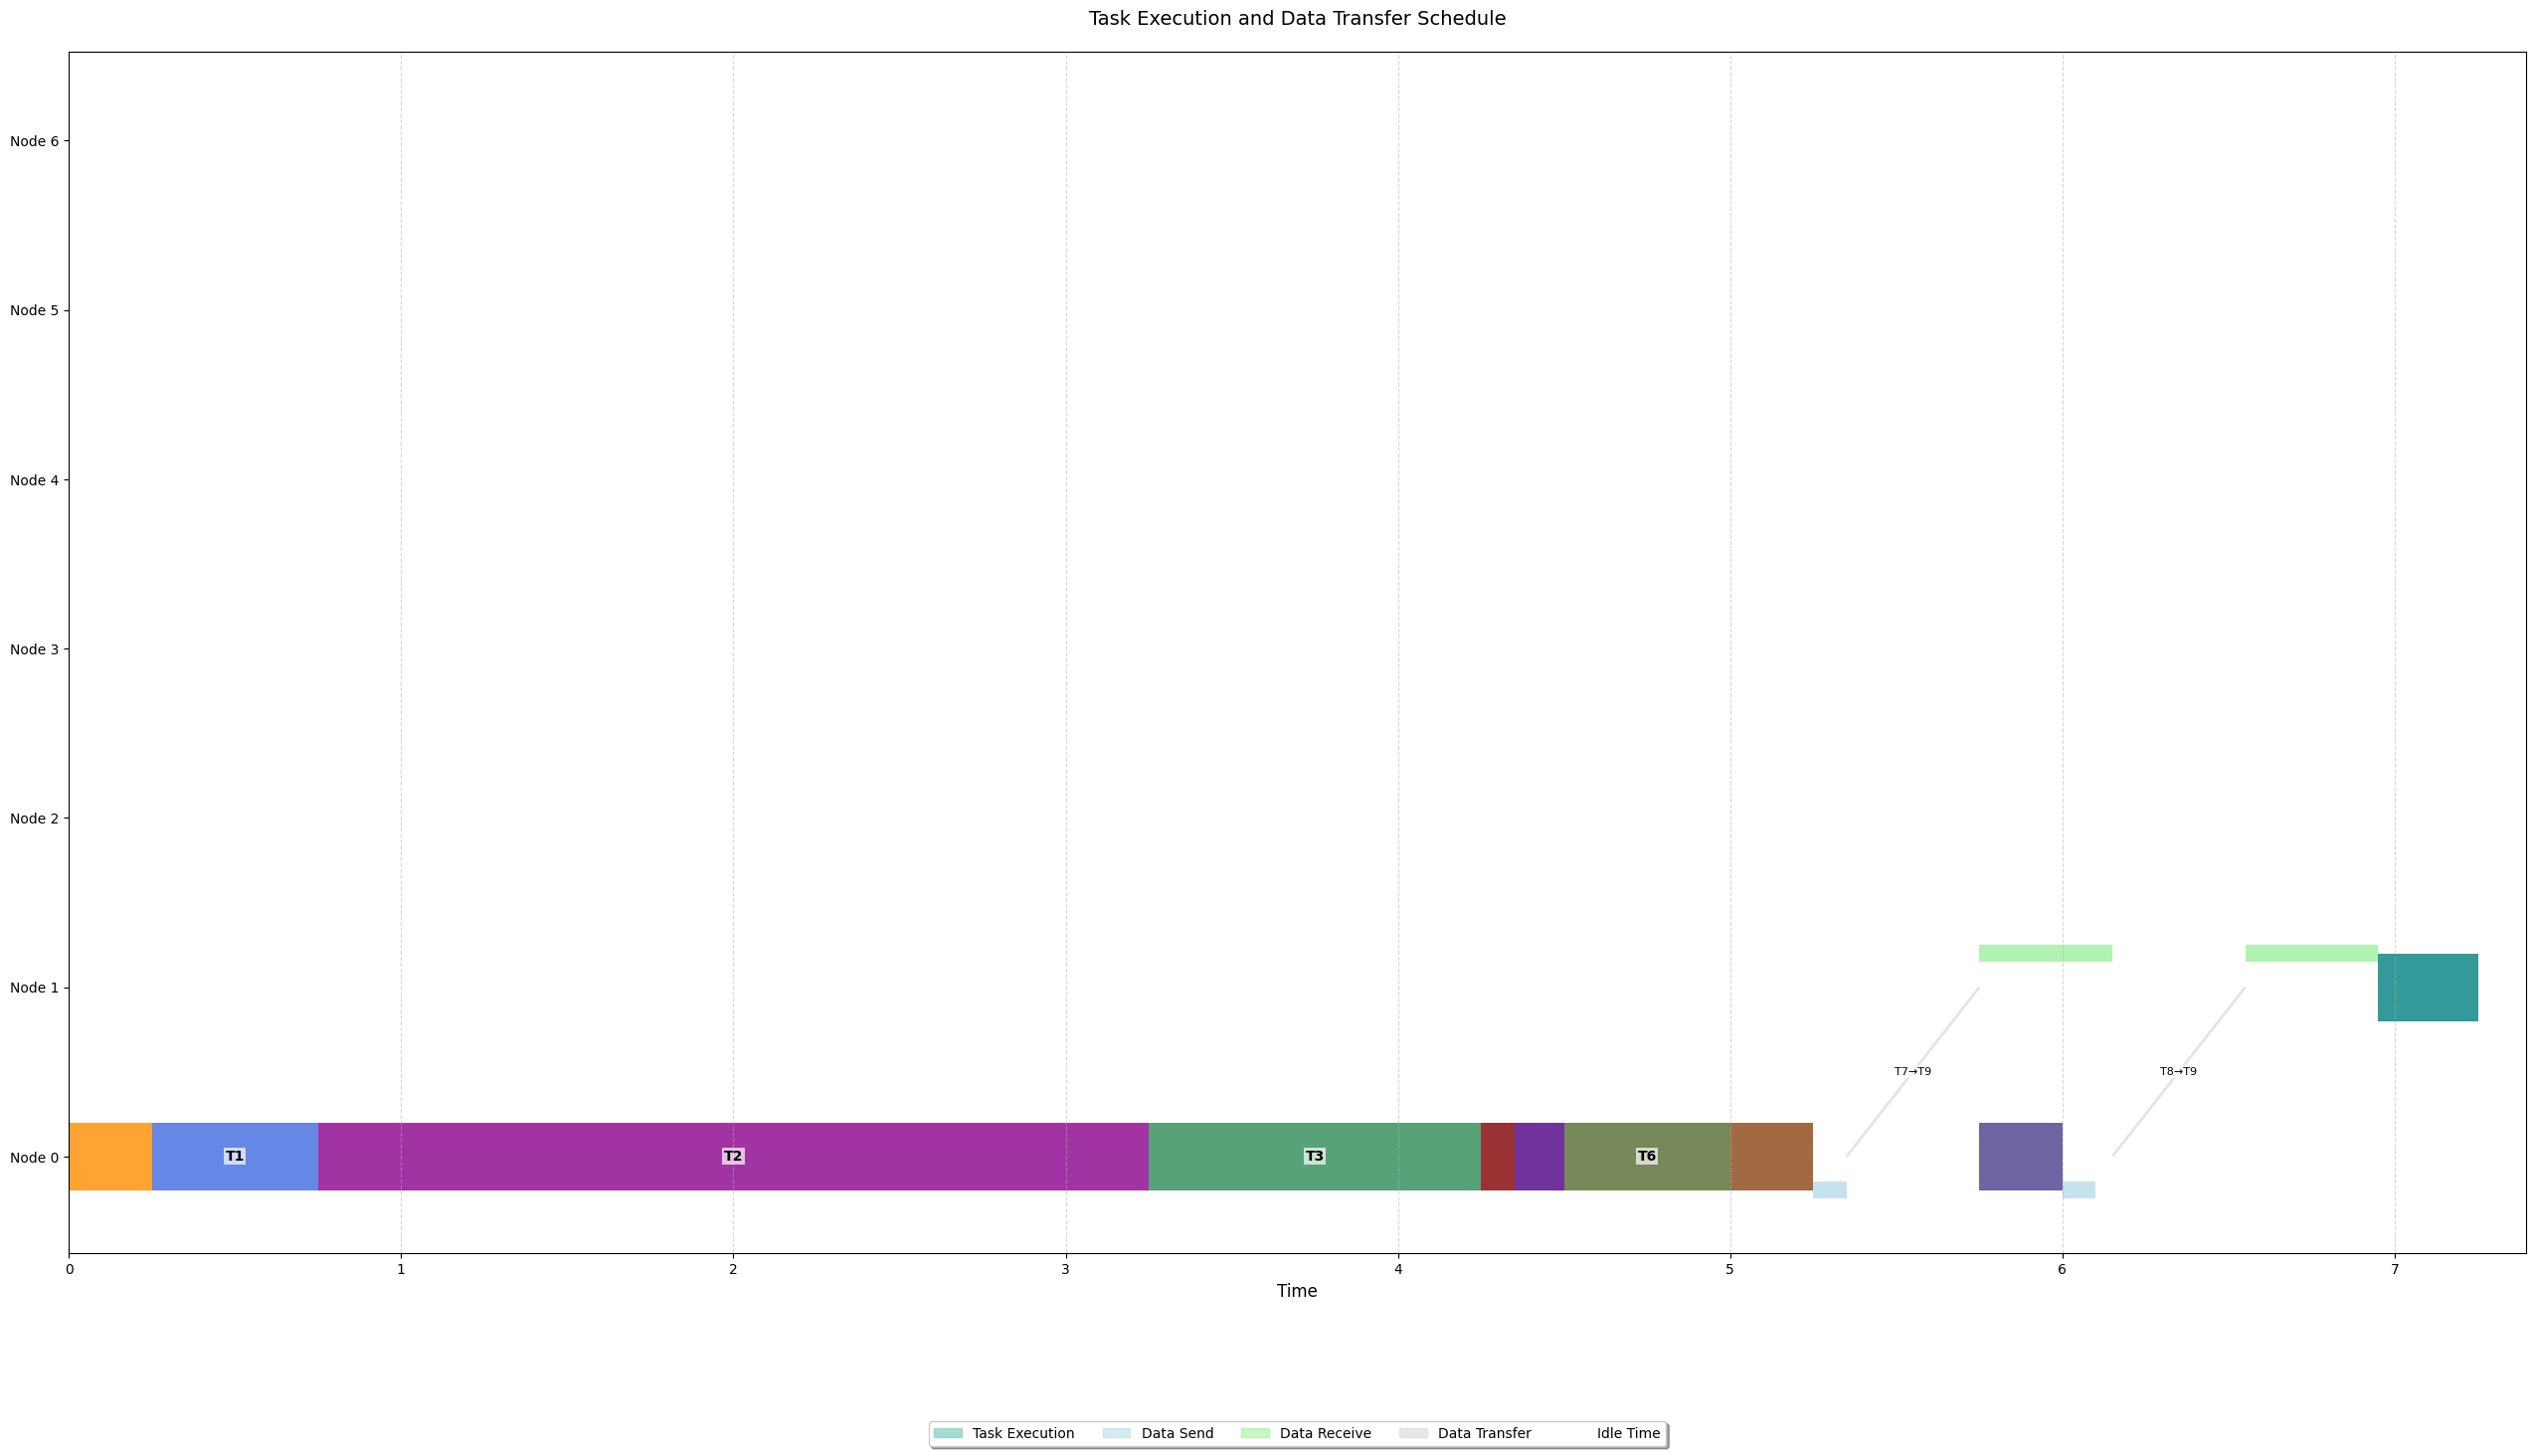

In [9]:
res.calculate_schedule([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
res.print_info()
res.create_gantt_chart()

In [10]:
problem.get_info([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

{'check_time_limit': 1,
 'minimize_hops': 0,
 'calculate_data_transfers': 1,
 'f_min_workload_node_0': 1.0,
 'f_min_workload_node_1': 1,
 'f_min_workload_node_2': 1,
 'f_min_workload_node_3': 1,
 'f_min_workload_node_4': 1,
 'f_min_workload_node_5': 1,
 'f_min_workload_node_6': 1,
 'f_min_workload_node_7': 1,
 'f_min_workload_node_8': 1,
 'c1_time_limit': 1,
 'c2_restriction_first_node': 0,
 'Свертка': inf,
 'Ограничения функций': {'check_time_limit': {'значение': 1,
   'ограничения': [1, 1]},
  'minimize_hops': {'значение': 0, 'ограничения': [0, 8]},
  'calculate_data_transfers': {'значение': 1, 'ограничения': [0, inf]}},
 'Ограничения специальных функций': {'узлы (0, 1)': {'get_node_workload': {'значение': 1,
    'ограничения': [0, 0.5],
    'узел': (0, 1)}}}}

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer
    
    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=1000, iterations=1000, update_history_coef = 1000)
    print(len(optimizer.history))
    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 0


NameError: name 'optimizer' is not defined

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = RandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import DirectedRandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = DirectedRandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import GeneticAlgorithm

    # Инициализация оптимизатора
    optimizer = GeneticAlgorithm(problem, population_size=100, generations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[f1_min_hop, f_min_workload_node_0, f_min_workload_node_1, f_min_workload_node_2, f_min_workload_node_3, f_min_workload_node_4, f_min_workload_node_5, f_min_workload_node_6, f_min_workload_node_7, f_min_workload_node_8], f_constraints=[c1_time_limit, c2_restriction_first_node], t_lim=5, net_speed=5000, bounds={0: [0,0]}, name="NETproblem_1")

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = RandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import DirectedRandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = DirectedRandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import GeneticAlgorithm

    # Инициализация оптимизатора
    optimizer = GeneticAlgorithm(problem, population_size=100, generations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
1/0

In [ ]:
print(optimizer.history)

In [ ]:
problem.scheduler.calculate_schedule([0, 0, 4, 0, 3, 8, 4, 8, 8, 8, 8, 2, 8])

In [ ]:
problem.scheduler.print_extended_info()

In [ ]:
problem.scheduler.create_gantt_chart()

In [ ]:
problem.evaluate([0,2,2,2,1,1,0,0,0,0,0,0,0])

In [ ]:
status(tuple([0,8,5,2,1,1,0,0,7,0,0,0,8]), problem)

In [ ]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import RandomSearchOptimizer

# Инициализация оптимизатора
optimizer = RandomSearchOptimizer(problem,iterations = 1000)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)

for i, item in enumerate(optimizer.history):
    optimizer.history[i]={**item, **network_status_calculation(tuple(item['vector']), problem)}

optimizer.save()

In [ ]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import GreedyOptimizer

# Инициализация оптимизатора
optimizer = GreedyOptimizer(problem)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)

for i, item in enumerate(optimizer.history):
    optimizer.history[i]={**item, **network_status_calculation(tuple(item['vector']), problem)}

optimizer.save()